# Figures from mouse brain COMMOT

author: @emilyekstrum 1/22/26

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from scipy import sparse
from libpysal.weights import KNN
from esda.moran import Moran

/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in simple svg and hvg commot resutls
commot_svg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_simple_svg.h5ad')
commot_hvg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_simple_hvg.h5ad')

# load in null models
#svgs
null_model_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null"
null_model_files = [f for f in os.listdir(null_model_dir) if f.endswith(".h5ad")]
null_models = defaultdict(list)
for f in null_model_files:
    path = os.path.join(null_model_dir, f)
    ad = sc.read_h5ad(path)
    # parse name
    parts = f.replace("mouse_commot_", "").replace(".h5ad", "").split("_null_")
    lr_set_name = parts[0]
    null_models[lr_set_name].append(ad)

#hvgs
null_model_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null"
null_model_files = [f for f in os.listdir(null_model_dir) if f.endswith(".h5ad")]
for f in null_model_files:
    path = os.path.join(null_model_dir, f)
    ad = sc.read_h5ad(path)
    # parse name
    parts = f.replace("mouse_commot_", "").replace(".h5ad", "").split("_null_")
    lr_set_name = parts[0]
    null_models[lr_set_name].append(ad)

In [3]:
# SVG vs HVG null comparison using
# chagne in effective transport distance and change in Moran's I (sender spot map)

# get inputs
# real data
svg_real = commot_svg
hvg_real = commot_hvg

# spatially null models (shuffled coordinates)
svg_nulls = null_models["simple_svg"]  
hvg_nulls = null_models["simple_hvg"] 

print(f"SVG null models: {len(svg_nulls)}")
print(f"HVG null models: {len(hvg_nulls)}")

# utils
def _to_coo(M):
    if M is None:
        return None
    if sparse.issparse(M):
        return M.tocoo()
    return sparse.coo_matrix(M)

def effective_transport_distance(ad, key):
    """Weighted mean edge length: sum(T_ij * dist_ij)/sum(T_ij)."""
    M = ad.obsp.get(key, None)
    if M is None:
        return np.nan
    M = _to_coo(M)
    if M.nnz == 0:
        return np.nan
    xy = np.asarray(ad.obsm["spatial"], dtype=float)
    dx = xy[M.row, 0] - xy[M.col, 0]
    dy = xy[M.row, 1] - xy[M.col, 1]
    dist = np.sqrt(dx * dx + dy * dy)
    w = M.data.astype(float)
    denom = w.sum()
    return float((w * dist).sum() / denom) if denom > 0 else np.nan

def outgoing_mass_per_spot(ad, key):
    """out_i = sum_j T_ij."""
    M = ad.obsp.get(key, None)
    if M is None:
        return None
    if sparse.issparse(M):
        return np.asarray(M.sum(axis=1)).ravel().astype(float)
    return np.sum(np.asarray(M), axis=1).ravel().astype(float)

def incoming_mass_per_spot(ad, key):
    """in_i = sum_j T_ji."""
    M = ad.obsp.get(key, None)
    if M is None:
        return None
    if sparse.issparse(M):
        return np.asarray(M.sum(axis=0)).ravel().astype(float)
    return np.sum(np.asarray(M), axis=0).ravel().astype(float)

def morans_I_sender(ad, key, k_neighbors=8):
    """Moran's I of sender (outgoing) mass across spatial KNN graph."""
    try:
        vals = outgoing_mass_per_spot(ad, key)
        if vals is None:
            return np.nan
        if not np.isfinite(vals).any():
            return np.nan
        xy = np.asarray(ad.obsm["spatial"], dtype=float)

        # KNN weights; row-standardized
        # Add error handling for KNN creation
        try:
            w = KNN.from_array(xy, k=k_neighbors)
            w.transform = "R"
        except Exception as e:
            print(f"Warning: KNN failed for {key}: {e}")
            return np.nan

        # Moran requires 1D array
        return float(Moran(vals, w).I)
    except Exception as e:
        print(f"Warning: Moran's I calculation failed for {key}: {e}")
        return np.nan

def delta_metric(real_val, null_vals):
    null_vals = np.asarray([v for v in null_vals if np.isfinite(v)], dtype=float)
    if null_vals.size == 0 or not np.isfinite(real_val):
        return np.nan
    return float(real_val - null_vals.mean())

def z_score_metric(real_val, null_vals):
    """Calculate z-score: (real - null_mean) / null_std"""
    null_vals = np.asarray([v for v in null_vals if np.isfinite(v)], dtype=float)
    if null_vals.size == 0 or not np.isfinite(real_val):
        return np.nan
    null_mean = null_vals.mean()
    null_std = null_vals.std()
    if null_std == 0:
        return np.nan
    return float((real_val - null_mean) / null_std)

# get pathway sum keys
# Keep only "pathway" keys (optional filter): those without a "-" after database prefix.
# Your pathway keys look like: "commot-cellchat-WNT" vs LR keys "commot-cellchat-Tgfb2-Tgfbr1_Tgfbr2"
def is_pathway_key(k):
    # pathway keys usually have 3 parts split by "-" (commot, cellchat, pathway)
    # LR keys ususally have 4 parts -> add the L and R
    return len(k.split("-")) == 3

svg_keys = [k for k in svg_real.obsp.keys() if is_pathway_key(k)]
hvg_keys = [k for k in hvg_real.obsp.keys() if is_pathway_key(k)]
common_keys = sorted(set(svg_keys).intersection(hvg_keys))

if len(common_keys) == 0:
    # or use all common keys
    common_keys = sorted(set(svg_real.obsp.keys()).intersection(hvg_real.obsp.keys()))

print("Number of common keys:", len(common_keys))

# delta for HVGs vs SVGs and all pathways
rows = []
for key in common_keys:
    # effective distance
    d_svg_real = effective_transport_distance(svg_real, key)
    d_svg_null = [effective_transport_distance(ad, key) for ad in svg_nulls]
    dd_svg = delta_metric(d_svg_real, d_svg_null)

    d_hvg_real = effective_transport_distance(hvg_real, key)
    d_hvg_null = [effective_transport_distance(ad, key) for ad in hvg_nulls]
    dd_hvg = delta_metric(d_hvg_real, d_hvg_null)

    # Moran's I on sender map
    I_svg_real = morans_I_sender(svg_real, key, k_neighbors=8)
    I_svg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in svg_nulls]
    dI_svg = delta_metric(I_svg_real, I_svg_null)

    I_hvg_real = morans_I_sender(hvg_real, key, k_neighbors=8)
    I_hvg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in hvg_nulls]
    dI_hvg = delta_metric(I_hvg_real, I_hvg_null)

    rows.append({
        "pathway": key,
        "delta_effdist_svg": dd_svg,
        "delta_effdist_hvg": dd_hvg,
        "delta_moran_svg": dI_svg,
        "delta_moran_hvg": dI_hvg,
        "effdist_svg_real": d_svg_real,
        "effdist_hvg_real": d_hvg_real,
        "moran_svg_real": I_svg_real,
        "moran_hvg_real": I_hvg_real,
    })

metrics_df = pd.DataFrame(rows)

# or focus on top pathways by real total mass (SVG real as reference)
def total_mass(ad, key):
    M = ad.obsp.get(key, None)
    if M is None:
        return 0.0
    return float(M.sum() if sparse.issparse(M) else np.sum(M))

metrics_df["total_mass_svg_real"] = metrics_df["pathway"].apply(lambda k: total_mass(svg_real, k))
metrics_df = metrics_df.sort_values("total_mass_svg_real", ascending=False)

# top N pathways to use
TOP_N = 25
plot_df = metrics_df.head(TOP_N).copy()

SVG null models: 5
HVG null models: 5
Number of common keys: 63


/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:272: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:229: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


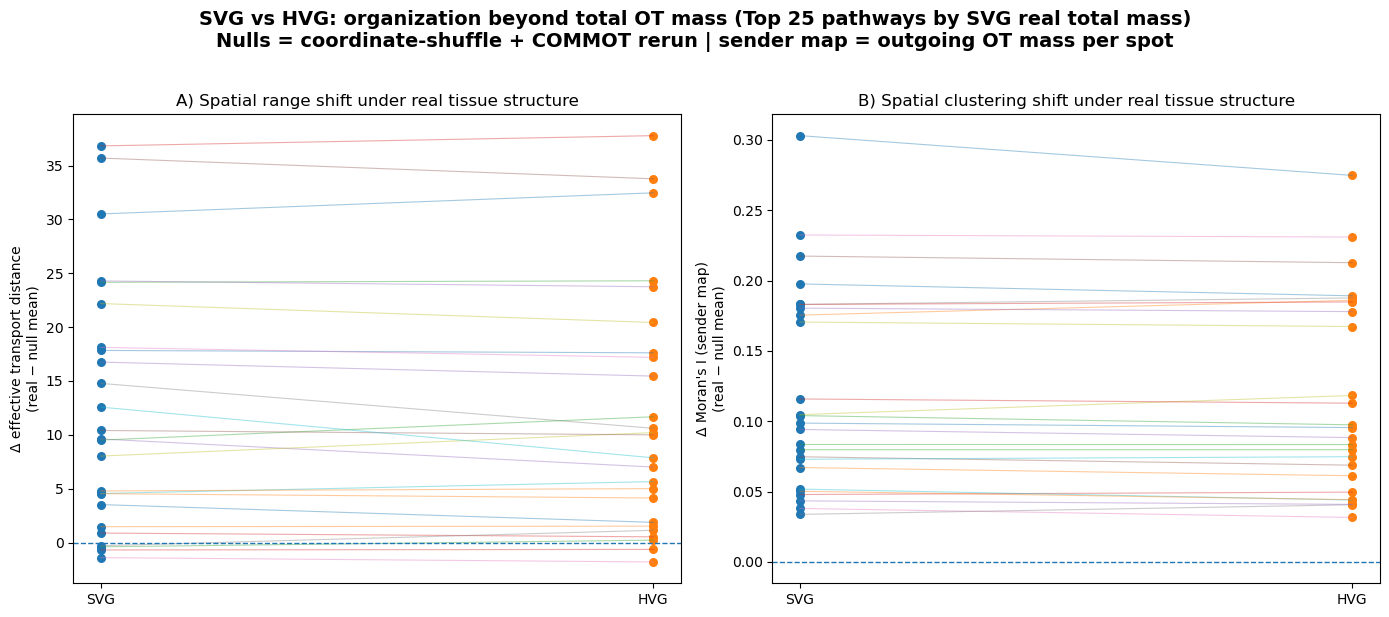

Example pathway for map: commot-cellchat-PSAP


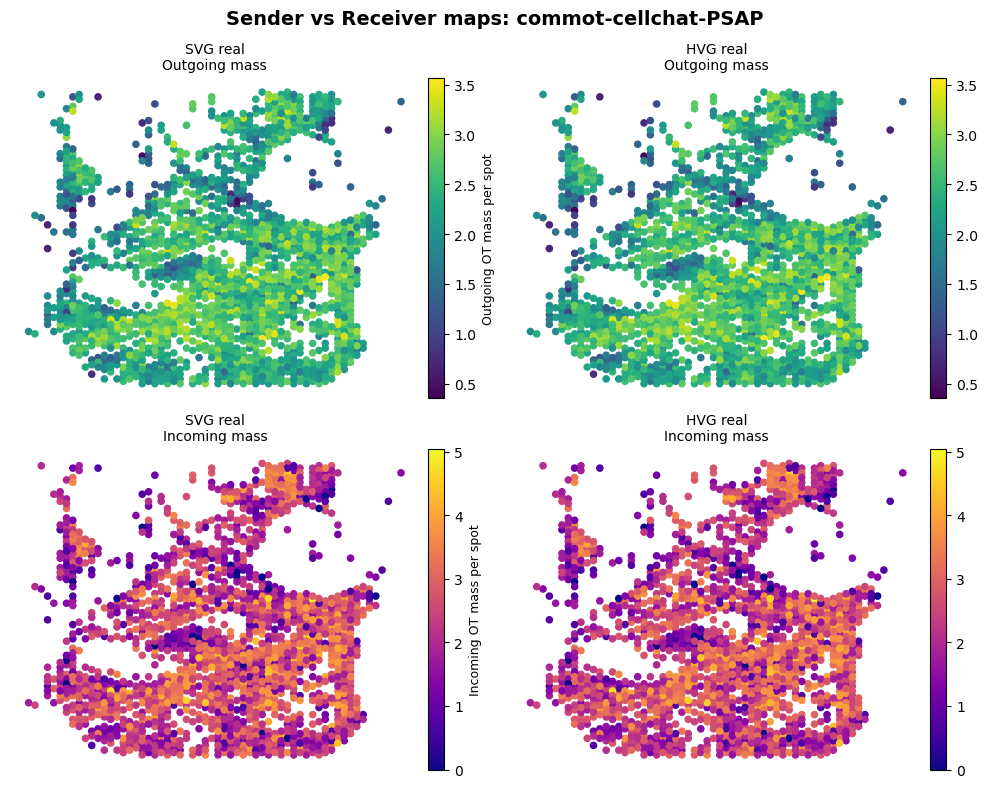

In [5]:
# plot: 2-panel fig w Δ distance Δ Moran's I
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# panel 1 -> Δ effective transport distance
ax = axes[0]
x_svg = np.zeros(len(plot_df)) + 0
x_hvg = np.zeros(len(plot_df)) + 1

ax.scatter(x_svg, plot_df["delta_effdist_svg"], s=30, label="SVG")
ax.scatter(x_hvg, plot_df["delta_effdist_hvg"], s=30, label="HVG")

# add lines pairing SVG/HVG for each pathway
for i, r in enumerate(plot_df.itertuples(index=False)):
    ax.plot([0, 1], [r.delta_effdist_svg, r.delta_effdist_hvg], linewidth=0.8, alpha=0.4)

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_xticks([0, 1])
ax.set_xticklabels(["SVG", "HVG"])
ax.set_ylabel("Δ effective transport distance\n(real − null mean)")
ax.set_title("A) Spatial range shift under real tissue structure")

# panel 2 -> Δ Moran's I of sender map
ax = axes[1]
ax.scatter(x_svg, plot_df["delta_moran_svg"], s=30, label="SVG")
ax.scatter(x_hvg, plot_df["delta_moran_hvg"], s=30, label="HVG")

for i, r in enumerate(plot_df.itertuples(index=False)):
    ax.plot([0, 1], [r.delta_moran_svg, r.delta_moran_hvg], linewidth=0.8, alpha=0.4)

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_xticks([0, 1])
ax.set_xticklabels(["SVG", "HVG"])
ax.set_ylabel("Δ Moran's I (sender map)\n(real − null mean)")
ax.set_title("B) Spatial clustering shift under real tissue structure")

fig.suptitle(
    f"SVG vs HVG: organization beyond total OT mass (Top {TOP_N} pathways by SVG real total mass)\n"
    f"Nulls = coordinate-shuffle + COMMOT rerun | sender map = outgoing OT mass per spot",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Plot 2 -> ex spatial map (SVG vs HVG, same pathway)
# use pathway with largest absolute difference in Δ Moran's I:
plot_df["delta_moran_diff"] = np.abs(plot_df["delta_moran_svg"] - plot_df["delta_moran_hvg"])
example_key = plot_df.sort_values("delta_moran_diff", ascending=False).iloc[0]["pathway"]
print("Example pathway for map:", example_key)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# get values for all plots to determine common color scale
all_outgoing_vals = []
all_incoming_vals = []

for ad in [svg_real, hvg_real]:
    out_vals = outgoing_mass_per_spot(ad, example_key)
    in_vals = incoming_mass_per_spot(ad, example_key)
    if out_vals is not None:
        all_outgoing_vals.extend(out_vals)
    if in_vals is not None:
        all_incoming_vals.extend(in_vals)

# use same color scales
vmin_out, vmax_out = np.min(all_outgoing_vals), np.max(all_outgoing_vals)
vmin_in, vmax_in = np.min(all_incoming_vals), np.max(all_incoming_vals)

# plot outgoing mass (top row)
for i, (ad, label) in enumerate([(svg_real, "SVG real"), (hvg_real, "HVG real")]):
    ax = axes[0, i]
    xy = np.asarray(ad.obsm["spatial"], dtype=float)
    vals = outgoing_mass_per_spot(ad, example_key)
    if vals is None:
        vals = np.zeros(ad.n_obs)

    sca = ax.scatter(xy[:, 0], xy[:, 1], c=vals, s=20, cmap="viridis", 
                     vmin=vmin_out, vmax=vmax_out)
    ax.invert_yaxis()
    ax.set_title(f"{label}\nOutgoing mass", fontsize=10)
    ax.axis("off")
    cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    if i == 0:  # add label to first colorbar
        cbar.set_label("Outgoing OT mass per spot", fontsize=9)

# plot incoming mass (bottom row)
for i, (ad, label) in enumerate([(svg_real, "SVG real"), (hvg_real, "HVG real")]):
    ax = axes[1, i]
    xy = np.asarray(ad.obsm["spatial"], dtype=float)
    vals = incoming_mass_per_spot(ad, example_key)
    if vals is None:
        vals = np.zeros(ad.n_obs)

    sca = ax.scatter(xy[:, 0], xy[:, 1], c=vals, s=20, cmap="plasma", 
                     vmin=vmin_in, vmax=vmax_in)
    ax.invert_yaxis()
    ax.set_title(f"{label}\nIncoming mass", fontsize=10)
    ax.axis("off")
    cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    if i == 0:  # add label to first colorbar
        cbar.set_label("Incoming OT mass per spot", fontsize=9)

fig.suptitle(
    f"Sender vs Receiver maps: {example_key}",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

# save metrics table
# metrics_df.to_csv("svg_vs_hvg_spatial_metrics.csv", index=False)


### Top plot
- Each line is a signaling pathway (in both SVGs and HVGs)
- Panel A:
    - y axis: delta effect transport dist -> how much father signals travel in tissue space compared to random tissue coordinates
        - pos value = signaling travels non-random distances & tissue structure influences paracrine range
        - neg value = tissue structure restricts signaling range compared to random tissue coordinates
    - Variable trends
        - SVG pathways have large positive shifts meaning they gain effective range from tissue structure information integration
        - HVG pathways are generally shifted upwards compared to SVGs -> longer effective transport distances, could be indicative of less spatial constraint

- Panel B: 
    - y axis: delta Moran's I -> spatial autocorrelation
        - pos value = signaling spot sources are spatially clustered more than by chance -> indicates spatial domains/niches
    - SVGs are consistently positive and have stronger Moran's I shifts compared to HVGs
    - HVGs also positive but are lower or aobut equal to SVGs
    - Tissue structure is important to both HVGs and SVGs, but more important for SVGs

**SVGs contain signaling programs that depend on spatial tissue organization beyond total communication strength alone. HVG-driven signaling is more spatially generic**

### Bottom plot
- SVG vs HVG incoming and outgoing OT mass for PSAP pathway (greatest delta Moran's I)
- Don't see an obvious visual difference between SVG and HVGs for incoming and outgoing OT mass.

Top 5 pathways for z-score analysis: ['commot-cellchat-PSAP', 'commot-cellchat-PTN', 'commot-cellchat-FGF', 'commot-cellchat-MK', 'commot-cellchat-VEGF']
Z-score data points: 20


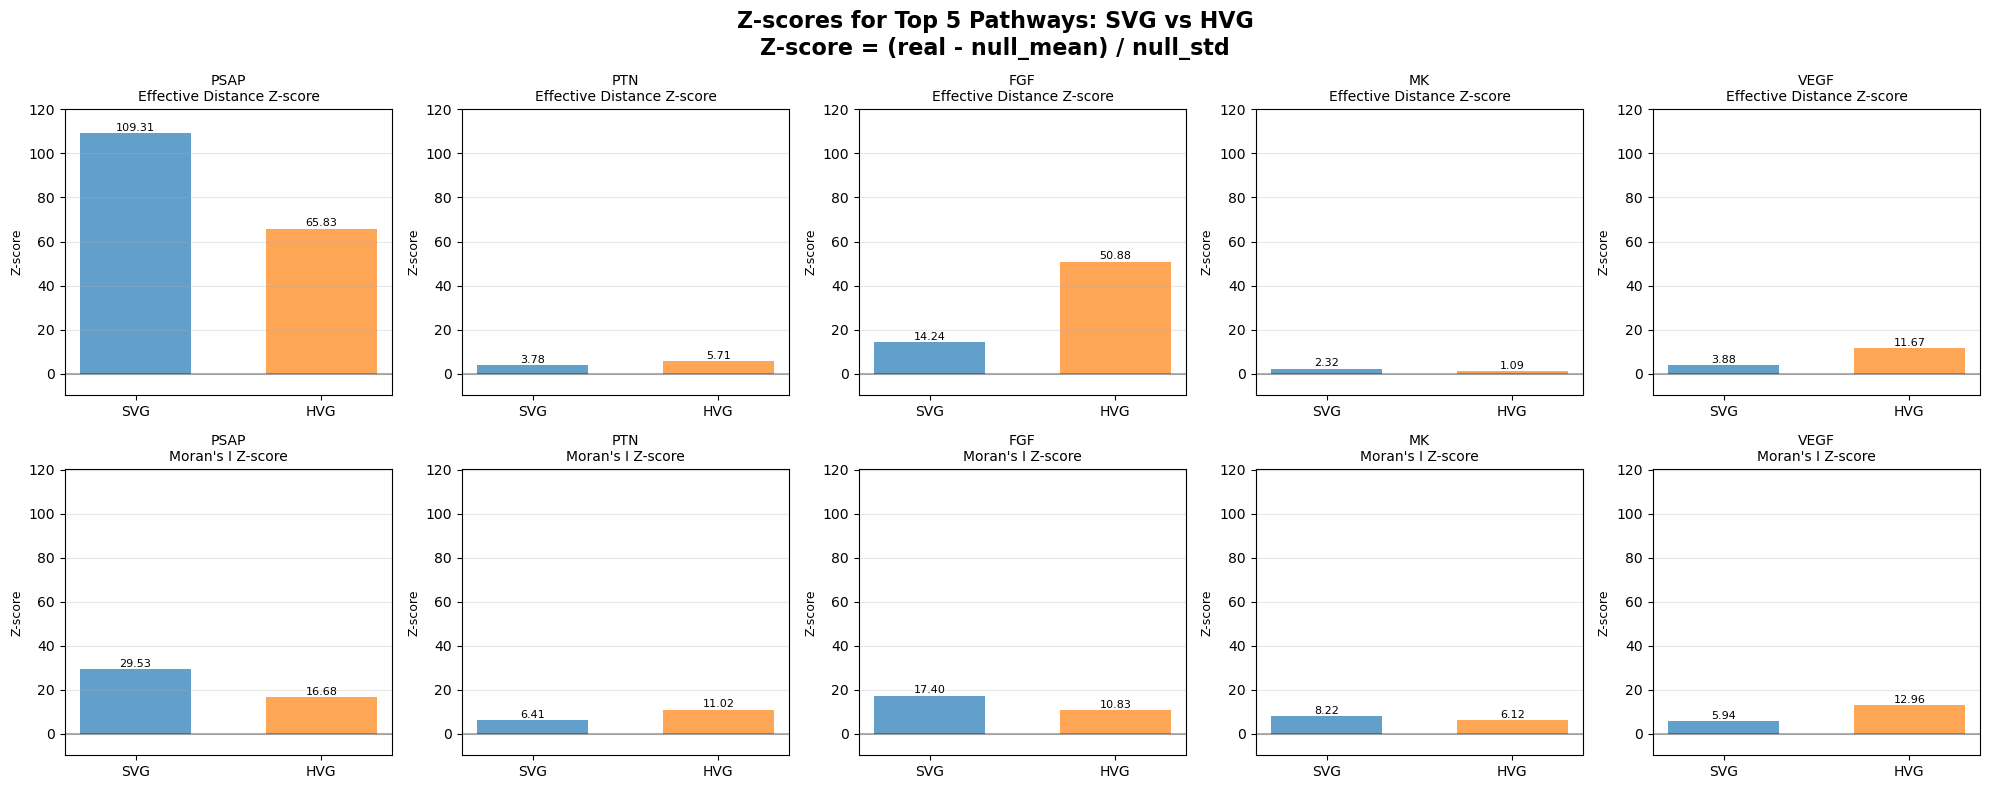


Z-score Summary Statistics:
                             mean     std    min      max
metric             method                                
Effective Distance HVG     27.036  29.315  1.091   65.829
                   SVG     26.706  46.420  2.325  109.306
Moran's I          HVG     11.522   3.825  6.125   16.677
                   SVG     13.501  10.092  5.945   29.530


In [7]:
# Z-score analysis for top pathways

# get top 5 pathways by total mass for z-score analysis
top_5_pathways = plot_df.head(5)['pathway'].tolist()
print(
    "Top 5 pathways for z-score analysis:", top_5_pathways
)

# z-scores for each pathway and metric
z_score_data = []

for key in top_5_pathways:
    # effective distance z-scores
    d_svg_real = effective_transport_distance(svg_real, key)
    d_svg_null = [effective_transport_distance(ad, key) for ad in svg_nulls]
    z_effdist_svg = z_score_metric(d_svg_real, d_svg_null)

    d_hvg_real = effective_transport_distance(hvg_real, key)
    d_hvg_null = [effective_transport_distance(ad, key) for ad in hvg_nulls]
    z_effdist_hvg = z_score_metric(d_hvg_real, d_hvg_null)

    # Moran's I z-scores
    I_svg_real = morans_I_sender(svg_real, key, k_neighbors=8)
    I_svg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in svg_nulls]
    z_moran_svg = z_score_metric(I_svg_real, I_svg_null)

    I_hvg_real = morans_I_sender(hvg_real, key, k_neighbors=8)
    I_hvg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in hvg_nulls]
    z_moran_hvg = z_score_metric(I_hvg_real, I_hvg_null)

    # data for plotting
    pathway_name = key.split("-")[-1]  # Get just the pathway name (e.g., "WNT")

    z_score_data.extend([
        {'pathway': pathway_name, 'metric': 'Effective Distance', 'method': 'SVG', 'z_score': z_effdist_svg},
        {'pathway': pathway_name, 'metric': 'Effective Distance', 'method': 'HVG', 'z_score': z_effdist_hvg},
        {'pathway': pathway_name, 'metric': "Moran's I", 'method': 'SVG', 'z_score': z_moran_svg},
        {'pathway': pathway_name, 'metric': "Moran's I", 'method': 'HVG', 'z_score': z_moran_hvg},
    ])

# convert to DataFrame
z_df = pd.DataFrame(z_score_data)
# remove NaN values
z_df = z_df.dropna(subset=['z_score'])

print(f"Z-score data points: {len(z_df)}")

# check valid z-score data
if len(z_df) == 0:
    print("Warning: No valid z-scores calculated. This could be because:")
    print("1. Insufficient null models (need >1 to calculate standard deviation)")
    print("2. All null values are identical (standard deviation = 0)")
    print("3. All calculations returned NaN values")
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for ax in axes.flat:
        ax.text(0.5, 0.5, "No valid z-scores\ncalculated", 
                ha='center', va='center', transform=ax.transAxes, 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(
        'Z-scores for Top 5 Pathways: SVG vs HVG\n'
        'No valid z-scores could be calculated from the data',
        fontsize=16,
        fontweight='bold',
        y=0.98
    )
    plt.tight_layout()
    plt.show()
else:
    # histogram plot
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, pathway in enumerate([p.split("-")[-1] for p in top_5_pathways]):
        # effective distance subplot
        ax_dist = axes[0, i]
        pathway_data = z_df[(z_df['pathway'] == pathway) & (z_df['metric'] == 'Effective Distance')]

        if len(pathway_data) > 0:
            svg_z = pathway_data[pathway_data['method'] == 'SVG']['z_score'].values
            hvg_z = pathway_data[pathway_data['method'] == 'HVG']['z_score'].values

            # plot bars
            x_pos = [0, 1]
            heights = [svg_z[0] if len(svg_z) > 0 else 0, hvg_z[0] if len(hvg_z) > 0 else 0]
            colors = ['#1f77b4', '#ff7f0e']  # Blue for SVG, orange for HVG

            bars = ax_dist.bar(x_pos, heights, color=colors, alpha=0.7, width=0.6)
            ax_dist.axhline(0, color='black', linestyle='-', alpha=0.3)
            ax_dist.set_xticks(x_pos)
            ax_dist.set_xticklabels(['SVG', 'HVG'], fontsize=10)
            ax_dist.set_title(f'{pathway}\nEffective Distance Z-score', fontsize=10)
            ax_dist.set_ylabel('Z-score', fontsize=9)
            ax_dist.grid(axis='y', alpha=0.3)

            # value labels on bars
            for bar, height in zip(bars, heights):
                if abs(height) > 0.1:  # show labels for non-zero values
                    ax_dist.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.1), 
                               f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
        else:
            # no data for this pathway
            ax_dist.text(0.5, 0.5, f"No data\nfor {pathway}", 
                        ha='center', va='center', transform=ax_dist.transAxes, 
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax_dist.set_xlim(0, 1)
            ax_dist.set_ylim(0, 1)
            ax_dist.set_xticks([])
            ax_dist.set_yticks([])

        # Moran's I subplot
        ax_moran = axes[1, i]
        pathway_data = z_df[(z_df['pathway'] == pathway) & (z_df['metric'] == "Moran's I")]

        if len(pathway_data) > 0:
            svg_z = pathway_data[pathway_data['method'] == 'SVG']['z_score'].values
            hvg_z = pathway_data[pathway_data['method'] == 'HVG']['z_score'].values

            # plot bars
            heights = [svg_z[0] if len(svg_z) > 0 else 0, hvg_z[0] if len(hvg_z) > 0 else 0]

            bars = ax_moran.bar(x_pos, heights, color=colors, alpha=0.7, width=0.6)
            ax_moran.axhline(0, color='black', linestyle='-', alpha=0.3)
            ax_moran.set_xticks(x_pos)
            ax_moran.set_xticklabels(['SVG', 'HVG'], fontsize=10)
            ax_moran.set_title(f'{pathway}\nMoran\'s I Z-score', fontsize=10)
            ax_moran.set_ylabel('Z-score', fontsize=9)
            ax_moran.grid(axis='y', alpha=0.3)

            # value labels on bars
            for bar, height in zip(bars, heights):
                if abs(height) > 0.1:  # Only show labels for non-zero values
                    ax_moran.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.1), 
                                f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
        else:
            # no data for this pathway
            ax_moran.text(0.5, 0.5, f"No data\nfor {pathway}", 
                         ha='center', va='center', transform=ax_moran.transAxes, 
                         fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax_moran.set_xlim(0, 1)
            ax_moran.set_ylim(0, 1)
            ax_moran.set_xticks([])
            ax_moran.set_yticks([])

    # use same y-axis ranges
    if len(z_df) > 0:
        all_z_scores = z_df['z_score'].values
        y_min, y_max = np.min(all_z_scores), np.max(all_z_scores)
        y_range = y_max - y_min
        y_margin = max(y_range * 0.1, 0.1)  # minimum margin

        for i, ax in enumerate(axes.flat):
            # set ylim for axes that have actual data (bars)
            if len(ax.patches) > 0:  # check if bars were plotted
                ax.set_ylim(y_min - y_margin, y_max + y_margin)

    fig.suptitle(
        'Z-scores for Top 5 Pathways: SVG vs HVG\n'
        'Z-score = (real - null_mean) / null_std',
        fontsize=16,
        fontweight='bold',
        y=0.98
    )

    plt.tight_layout()
    plt.show()

    # summary statistics
    print("\nZ-score Summary Statistics:")
    if len(z_df) > 0:
        print(z_df.groupby(['metric', 'method'])['z_score'].agg(['mean', 'std', 'min', 'max']).round(3))
    else:
        print("No valid z-scores to summarize.")


### Z score plots: effect size relative to random spatial models
- PSAP has a strong structural dependence compared to the other pathways, which have varying spatial dependence
- Less spatial pathways may have more long-range pathways in which the ligand is able to diffuse through larger distances in the tissue space
- PSAP also has a tighter spatial domain (greater z score for Moran's I)
- Similar to effective distance z-score, the other pathways are variable in trends, reflecting biological heterogenity in spatial domains for signaling programs 

### Summary table: 
- effective distance
    - mean z scores are about equal between SVGs and HVGs, so SVGs do not globally increase signaling range more than HVGs
    - larger std for SVGs -> SVG effects are highly pathway specific
- Moran's I
    - SVGs have higher mean clustering zscore, indicating SVG-driven signaling is more spatially clustered than HVG signaling
    - SVGs also have greater variablitiy similarly to effective distance
        - SVGs dominate max values for both -> highly clustered signaling programs may be only SVG-driven 

**HVGs capture average signaling patterns. SVGs encode sptaial extreme information that define tissue organization**


Calculating z-scores for all pathways


/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:272: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/opt/anaconda3/envs/commot312/lib/python3.12/site-packages/esda/moran.py:229: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


Total z-score data points: 236 (from 63 pathways)


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_49327/3058649495.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, positions=positions, patch_artist=True,


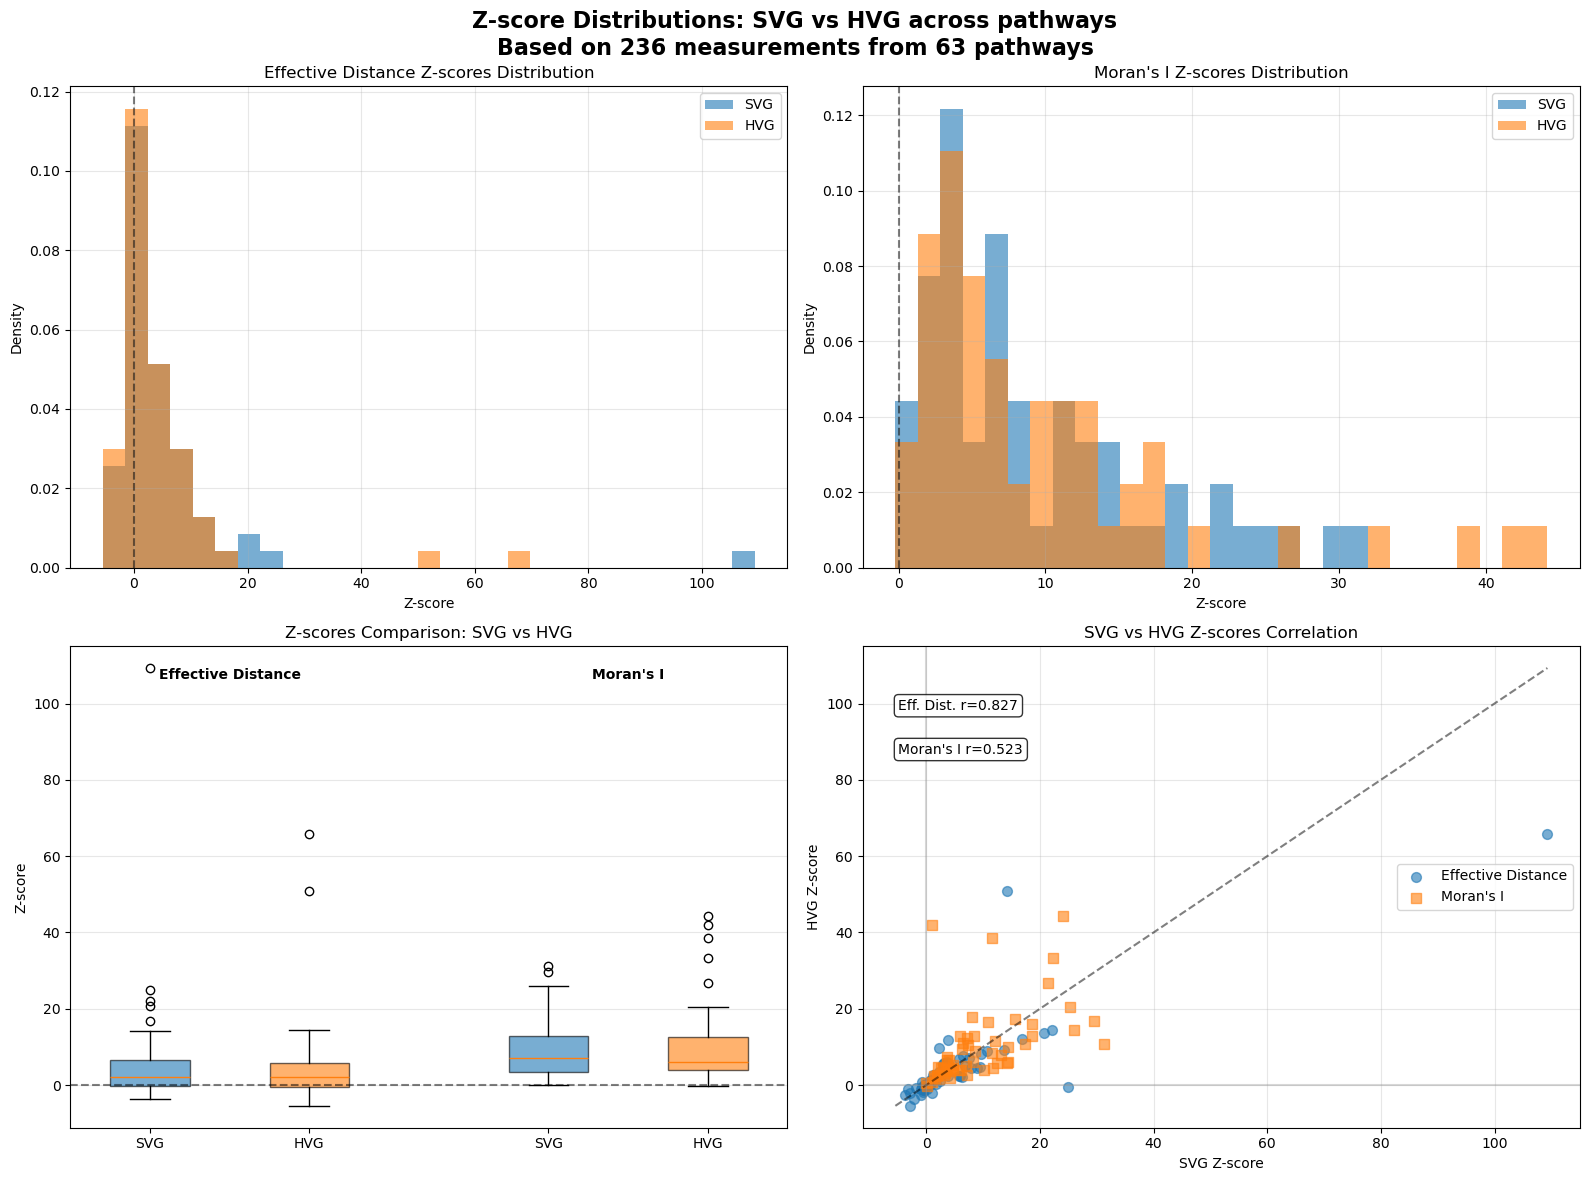


Distribution Statistics:

Effective Distance:
  SVG: mean=5.704, std=15.058, median=2.227, n=59
        |z| > 1.96: 35 (59.3%)
        |z| > 2.58: 31 (52.5%)
  HVG: mean=4.653, std=11.135, median=2.076, n=59
        |z| > 1.96: 36 (61.0%)
        |z| > 2.58: 28 (47.5%)

Moran's I:
  SVG: mean=9.196, std=7.803, median=7.021, n=59
        |z| > 1.96: 51 (86.4%)
        |z| > 2.58: 49 (83.1%)
  HVG: mean=9.843, std=9.845, median=6.125, n=59
        |z| > 1.96: 53 (89.8%)
        |z| > 2.58: 51 (86.4%)


In [8]:
# Dist plots of z-scores across pathways

# z-scores for ALL pathways
print("\nCalculating z-scores for all pathways")
all_z_score_data = []

for key in common_keys:
    # effective distance z-scores
    d_svg_real = effective_transport_distance(svg_real, key)
    d_svg_null = [effective_transport_distance(ad, key) for ad in svg_nulls]
    z_effdist_svg = z_score_metric(d_svg_real, d_svg_null)
    
    d_hvg_real = effective_transport_distance(hvg_real, key)
    d_hvg_null = [effective_transport_distance(ad, key) for ad in hvg_nulls]
    z_effdist_hvg = z_score_metric(d_hvg_real, d_hvg_null)
    
    # Moran's I z-scores
    I_svg_real = morans_I_sender(svg_real, key, k_neighbors=8)
    I_svg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in svg_nulls]
    z_moran_svg = z_score_metric(I_svg_real, I_svg_null)
    
    I_hvg_real = morans_I_sender(hvg_real, key, k_neighbors=8)
    I_hvg_null = [morans_I_sender(ad, key, k_neighbors=8) for ad in hvg_nulls]
    z_moran_hvg = z_score_metric(I_hvg_real, I_hvg_null)
    
    # get data for plotting
    pathway_name = key.split("-")[-1]
    
    all_z_score_data.extend([
        {'pathway': pathway_name, 'metric': 'Effective Distance', 'method': 'SVG', 'z_score': z_effdist_svg, 'full_key': key},
        {'pathway': pathway_name, 'metric': 'Effective Distance', 'method': 'HVG', 'z_score': z_effdist_hvg, 'full_key': key},
        {'pathway': pathway_name, 'metric': "Moran's I", 'method': 'SVG', 'z_score': z_moran_svg, 'full_key': key},
        {'pathway': pathway_name, 'metric': "Moran's I", 'method': 'HVG', 'z_score': z_moran_hvg, 'full_key': key},
    ])

# convert to DataFrame and remove NaN values
all_z_df = pd.DataFrame(all_z_score_data)
all_z_df_clean = all_z_df.dropna(subset=['z_score'])

print(f"Total z-score data points: {len(all_z_df_clean)} (from {len(common_keys)} pathways)")

if len(all_z_df_clean) > 0:
    # distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # plot 1 -> histogram of effective distance z-scores
    ax = axes[0, 0]
    eff_dist_data = all_z_df_clean[all_z_df_clean['metric'] == 'Effective Distance']
    svg_eff = eff_dist_data[eff_dist_data['method'] == 'SVG']['z_score'].values
    hvg_eff = eff_dist_data[eff_dist_data['method'] == 'HVG']['z_score'].values
    
    if len(svg_eff) > 0 and len(hvg_eff) > 0:
        bins = np.linspace(min(np.min(svg_eff), np.min(hvg_eff)), 
                          max(np.max(svg_eff), np.max(hvg_eff)), 30)
        ax.hist(svg_eff, bins=bins, alpha=0.6, label='SVG', color='#1f77b4', density=True)
        ax.hist(hvg_eff, bins=bins, alpha=0.6, label='HVG', color='#ff7f0e', density=True)
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Z-score')
        ax.set_ylabel('Density')
        ax.set_title('Effective Distance Z-scores Distribution')
        ax.legend()
        ax.grid(alpha=0.3)
    
    # plot 2: histogram of Moran's I z-scores
    ax = axes[0, 1]
    moran_data = all_z_df_clean[all_z_df_clean['metric'] == "Moran's I"]
    svg_moran = moran_data[moran_data['method'] == 'SVG']['z_score'].values
    hvg_moran = moran_data[moran_data['method'] == 'HVG']['z_score'].values
    
    if len(svg_moran) > 0 and len(hvg_moran) > 0:
        bins = np.linspace(min(np.min(svg_moran), np.min(hvg_moran)), 
                          max(np.max(svg_moran), np.max(hvg_moran)), 30)
        ax.hist(svg_moran, bins=bins, alpha=0.6, label='SVG', color='#1f77b4', density=True)
        ax.hist(hvg_moran, bins=bins, alpha=0.6, label='HVG', color='#ff7f0e', density=True)
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Z-score')
        ax.set_ylabel('Density')
        ax.set_title("Moran's I Z-scores Distribution")
        ax.legend()
        ax.grid(alpha=0.3)
    
    # plot 3: box plots comparing SVG vs HVG for both metrics
    ax = axes[1, 0]
    plot_data = []
    for _, row in all_z_df_clean.iterrows():
        plot_data.append({
            'Method': row['method'],
            'Metric': row['metric'],
            'Z-score': row['z_score']
        })
    
    if len(plot_data) > 0:
        plot_data_df = pd.DataFrame(plot_data)
        
        # box plot
        methods = ['SVG', 'HVG']
        metrics = ['Effective Distance', "Moran's I"]
        positions = []
        box_data = []
        labels = []
        colors = []
        
        pos = 0
        for metric in metrics:
            for method in methods:
                subset = plot_data_df[(plot_data_df['Method'] == method) & 
                                    (plot_data_df['Metric'] == metric)]
                if len(subset) > 0:
                    positions.append(pos)
                    box_data.append(subset['Z-score'].values)
                    labels.append(f"{method}\n{metric}")
                    colors.append('#1f77b4' if method == 'SVG' else '#ff7f0e')
                pos += 1
            pos += 0.5  # add space between metrics
        
        if len(box_data) > 0:
            bp = ax.boxplot(box_data, positions=positions, patch_artist=True, 
                           labels=[l.split('\n')[0] for l in labels])
            
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            
            ax.axhline(0, color='black', linestyle='--', alpha=0.5)
            ax.set_ylabel('Z-score')
            ax.set_title('Z-scores Comparison: SVG vs HVG')
            ax.grid(axis='y', alpha=0.3)
            
            # add metric labels
            metric_positions = [0.5, 3]
            for pos, metric in zip(metric_positions, metrics):
                ax.text(pos, ax.get_ylim()[1] * 0.95, metric, 
                       ha='center', va='top', fontweight='bold')
    
    # plot 4 -> scatter plot showing correlation between SVG and HVG z-scores
    ax = axes[1, 1]
    
    # pivot data to get SVG vs HVG comparison
    pivot_data = []
    for metric in ['Effective Distance', "Moran's I"]:
        metric_data = all_z_df_clean[all_z_df_clean['metric'] == metric]
        svg_scores = metric_data[metric_data['method'] == 'SVG'].set_index('full_key')['z_score']
        hvg_scores = metric_data[metric_data['method'] == 'HVG'].set_index('full_key')['z_score']
        
        # get common pathways
        common_pathways = svg_scores.index.intersection(hvg_scores.index)
        
        for pathway in common_pathways:
            pivot_data.append({
                'pathway': pathway,
                'metric': metric,
                'svg_zscore': svg_scores[pathway],
                'hvg_zscore': hvg_scores[pathway]
            })
    
    if len(pivot_data) > 0:
        pivot_df = pd.DataFrame(pivot_data)
        
        # plot scatter for each metric
        for metric, color, marker in [('Effective Distance', '#1f77b4', 'o'), 
                                     ("Moran's I", '#ff7f0e', 's')]:
            metric_subset = pivot_df[pivot_df['metric'] == metric]
            if len(metric_subset) > 0:
                ax.scatter(metric_subset['svg_zscore'], metric_subset['hvg_zscore'], 
                          color=color, alpha=0.6, s=50, label=metric, marker=marker)
        
        # add diagonal line 
        all_scores = np.concatenate([pivot_df['svg_zscore'], pivot_df['hvg_zscore']])
        min_score, max_score = np.min(all_scores), np.max(all_scores)
        ax.plot([min_score, max_score], [min_score, max_score], 
               'k--', alpha=0.5)
        
        # add quadrant lines
        ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
        ax.axvline(0, color='gray', linestyle='-', alpha=0.3)
        
        ax.set_xlabel('SVG Z-score')
        ax.set_ylabel('HVG Z-score')
        ax.set_title('SVG vs HVG Z-scores Correlation')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # calculate and show correlation
        if len(pivot_df) > 5:  # only calc corr if enough data points
            from scipy.stats import pearsonr
            corr_eff, p_eff = pearsonr(
                pivot_df[pivot_df['metric'] == 'Effective Distance']['svg_zscore'],
                pivot_df[pivot_df['metric'] == 'Effective Distance']['hvg_zscore']
            ) if len(pivot_df[pivot_df['metric'] == 'Effective Distance']) > 1 else (np.nan, np.nan)
            
            corr_moran, p_moran = pearsonr(
                pivot_df[pivot_df['metric'] == "Moran's I"]['svg_zscore'],
                pivot_df[pivot_df['metric'] == "Moran's I"]['hvg_zscore']
            ) if len(pivot_df[pivot_df['metric'] == "Moran's I"]) > 1 else (np.nan, np.nan)
            
            # add correlation text
            text_y = max_score * 0.9
            if not np.isnan(corr_eff):
                ax.text(min_score * 0.9, text_y, f'Eff. Dist. r={corr_eff:.3f}', 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            if not np.isnan(corr_moran):
                ax.text(min_score * 0.9, text_y - (max_score - min_score) * 0.1, 
                       f"Moran's I r={corr_moran:.3f}",
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    fig.suptitle(
        'Z-score Distributions: SVG vs HVG across pathways\n'
        f'Based on {len(all_z_df_clean)} measurements from {len(common_keys)} pathways',
        fontsize=16,
        fontweight='bold',
        y=0.98
    )
    
    plt.tight_layout()
    plt.show()
    
    # statistical summary
    print("\nDistribution Statistics:")
    
    for metric in ['Effective Distance', "Moran's I"]:
        print(f"\n{metric}:")
        metric_data = all_z_df_clean[all_z_df_clean['metric'] == metric]
        
        for method in ['SVG', 'HVG']:
            method_data = metric_data[metric_data['method'] == method]['z_score']
            if len(method_data) > 0:
                print(f"  {method}: mean={method_data.mean():.3f}, std={method_data.std():.3f}, "
                     f"median={method_data.median():.3f}, n={len(method_data)}")
                print(f"        |z| > 1.96: {(np.abs(method_data) > 1.96).sum()} "
                     f"({(np.abs(method_data) > 1.96).mean()*100:.1f}%)")
                print(f"        |z| > 2.58: {(np.abs(method_data) > 2.58).sum()} "
                     f"({(np.abs(method_data) > 2.58).mean()*100:.1f}%)")

else:
    print("No valid z-scores available for distribution plotting.")

### Top left panel: Effective distance z-score dist
- Large overlap near low z scores
- SVG has a heavier right tail -> extreme and rare large z-scores for a small subset of SVG pathways that have extreme spatial-dependent signaling range

### Top right panel: Moran's I z-score dist
- Very slight right shift for SVGs -> systematically encode stronnger spatial clsutering than HVGs across pathways

### Bottom left panel: Boxplot
- Median z-scores across all 4 metrics are about the same
- larger SVG spread for Moran's I

### Bottom right panel: z-score correlation scatter plot
- effective distance r = 0.83 -> strong correlation
    - pathways that are spatially dependent under HVG filter usually are also spatially dependent for SVG filtering
- moran's I r = 0.52 -> weaker correlation 
    - spatial clustering is partially decoupled between SVGs and HVGs 

### Stats table: 
- effective distance
    - higher mean for SVGs
    - greater variability for SVGs -> more heterogeneous SVG-driven signaling range effects -> some pathways have heavy spatial constraints
- Moran's I
    - about equal means
    - HVGs are more variable

**SVGs complement spatial organization from HVG pathways**

In [10]:
# load in L, R & LR svg/hvg commot resutls
commot_L_svg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_L_svg.h5ad')
commot_LR_svg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_LR_svg.h5ad')
commot_R_svg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_R_svg.h5ad')

commot_L_hvg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_L_hvg.h5ad')
commot_LR_hvg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_LR_hvg.h5ad')
commot_R_hvg = sc.read_h5ad('/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_R_hvg.h5ad')

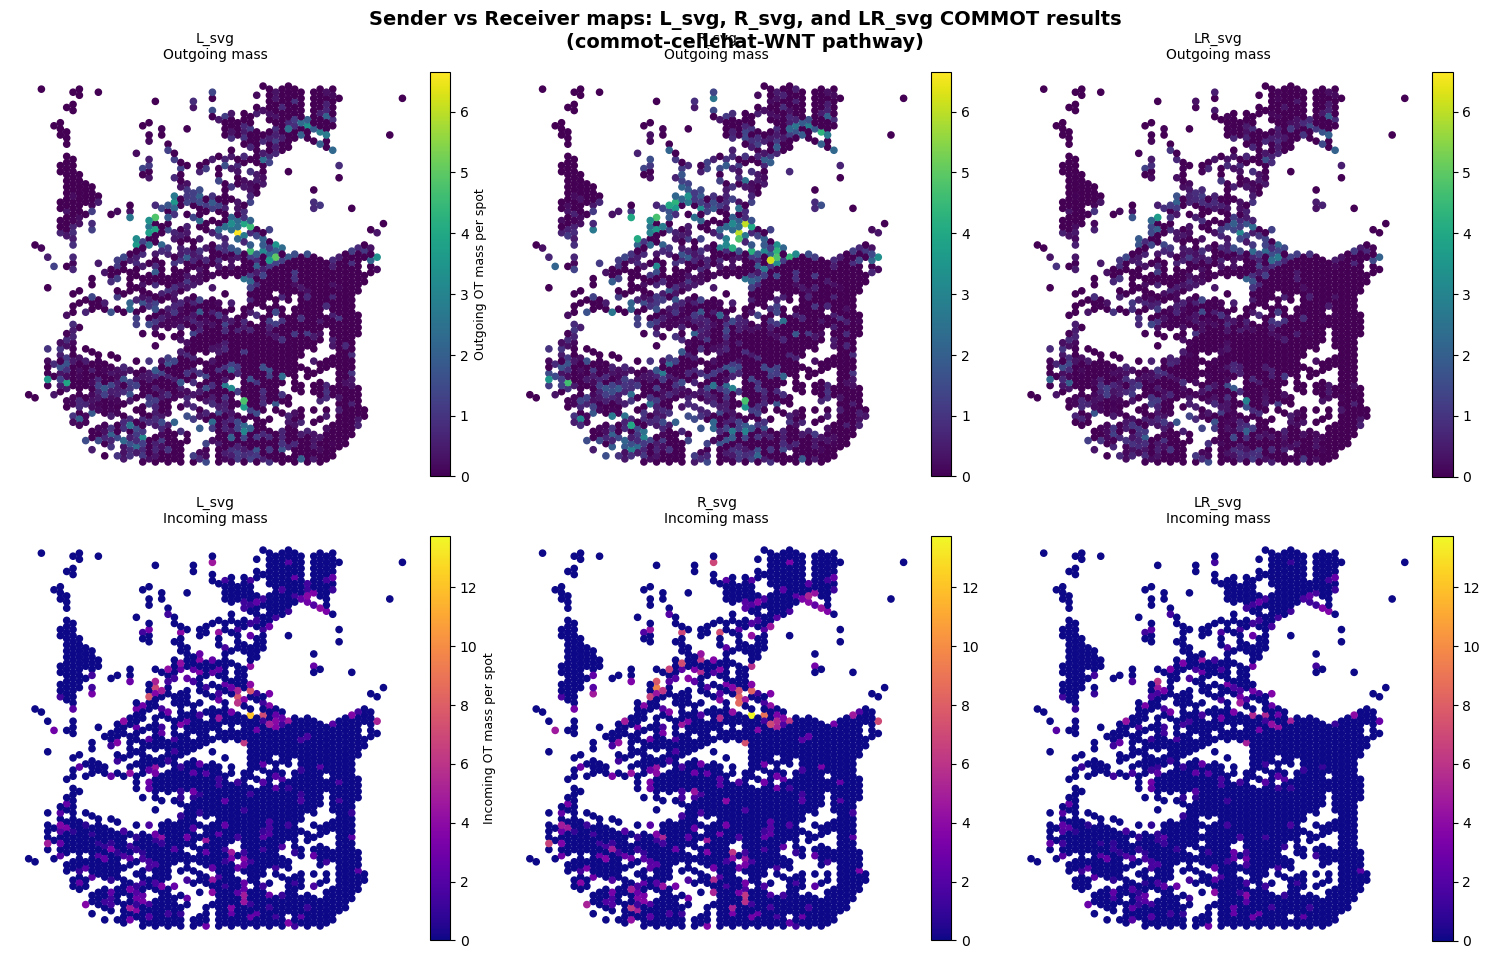

In [43]:
# side by side plot of L_svg, R_svg, and LR_svg receptor vs ligand transport maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# get values for all plots to determine common color scales
all_outgoing_vals = []
all_incoming_vals = []
pathway_key = "commot-cellchat-WNT"

for ad in [commot_L_svg, commot_R_svg, commot_LR_hvg]:
    out_vals = outgoing_mass_per_spot(ad, pathway_key)
    in_vals = incoming_mass_per_spot(ad, pathway_key)
    if out_vals is not None:
        all_outgoing_vals.extend(out_vals)
    if in_vals is not None:
        all_incoming_vals.extend(in_vals)

# use common color scales
vmin_out, vmax_out = np.min(all_outgoing_vals), np.max(all_outgoing_vals)
vmin_in, vmax_in = np.min(all_incoming_vals), np.max(all_incoming_vals)

# plot outgoing OT mass (top row)
for i, (ad, label) in enumerate([(commot_L_svg, "L_svg"), (commot_R_svg, "R_svg"), (commot_LR_hvg, "LR_svg")]):
    ax = axes[0, i]
    xy = np.asarray(ad.obsm["spatial"], dtype=float)
    vals = outgoing_mass_per_spot(ad, pathway_key)
    if vals is None:
        vals = np.zeros(ad.n_obs)

    sca = ax.scatter(xy[:, 0], xy[:, 1], c=vals, s=20, cmap="viridis", 
                     vmin=vmin_out, vmax=vmax_out)
    ax.invert_yaxis()
    ax.set_title(f"{label}\nOutgoing mass", fontsize=10)
    ax.axis("off")
    cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    if i == 0:  # add label to first colorbar
        cbar.set_label("Outgoing OT mass per spot", fontsize=9)

# plot incoming OT mass (bottom row)
for i, (ad, label) in enumerate([(commot_L_svg, "L_svg"), (commot_R_svg, "R_svg"), (commot_LR_hvg, "LR_svg")]):
    ax = axes[1, i]
    xy = np.asarray(ad.obsm["spatial"], dtype=float)
    vals = incoming_mass_per_spot(ad, pathway_key)
    if vals is None:
        vals = np.zeros(ad.n_obs)

    sca = ax.scatter(xy[:, 0], xy[:, 1], c=vals, s=20, cmap="plasma", 
                     vmin=vmin_in, vmax=vmax_in)
    ax.invert_yaxis()
    ax.set_title(f"{label}\nIncoming mass", fontsize=10)
    ax.axis("off")
    cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    if i == 0:  # add label to first colorbar
        cbar.set_label("Incoming OT mass per spot", fontsize=9)

fig.suptitle(
    f"Sender vs Receiver maps: L_svg, R_svg, and LR_svg COMMOT results\n({pathway_key} pathway)",
    fontsize=14,
    fontweight="bold",
    y=0.95,
)
plt.tight_layout()
plt.show()

Available pathways in L_svg:
Found 47 pathways: ['commot-cellchat-AGT', 'commot-cellchat-APELIN', 'commot-cellchat-BMP', 'commot-cellchat-CALCR', 'commot-cellchat-CCK']

Available pathways in R_svg:
Found 56 pathways: ['commot-cellchat-ACTIVIN', 'commot-cellchat-AMH', 'commot-cellchat-ANGPT', 'commot-cellchat-ANGPTL', 'commot-cellchat-BMP']

Available pathways in LR_svg:
Found 39 pathways: ['commot-cellchat-BMP', 'commot-cellchat-CCK', 'commot-cellchat-CCL', 'commot-cellchat-CRH', 'commot-cellchat-CSF']

Common pathways across all three: 39

Top 10 pathways by total mass:
  PSAP: 11740.62
  PTN: 9602.62
  FGF: 6514.04
  MK: 5020.46
  VEGF: 3169.58
  GAS: 2612.29
  GRN: 1982.80
  WNT: 1922.23
  PDGF: 1842.14
  BMP: 1611.73
  CSF: 1491.68
  SPP1: 1334.33
  OPIOID: 1173.32
  SEMA3: 1114.21
  KIT: 1092.72
  ncWNT: 1069.79
  EGF: 998.82
  VISFATIN: 787.36
  ENHO: 667.27
  IGF: 653.22


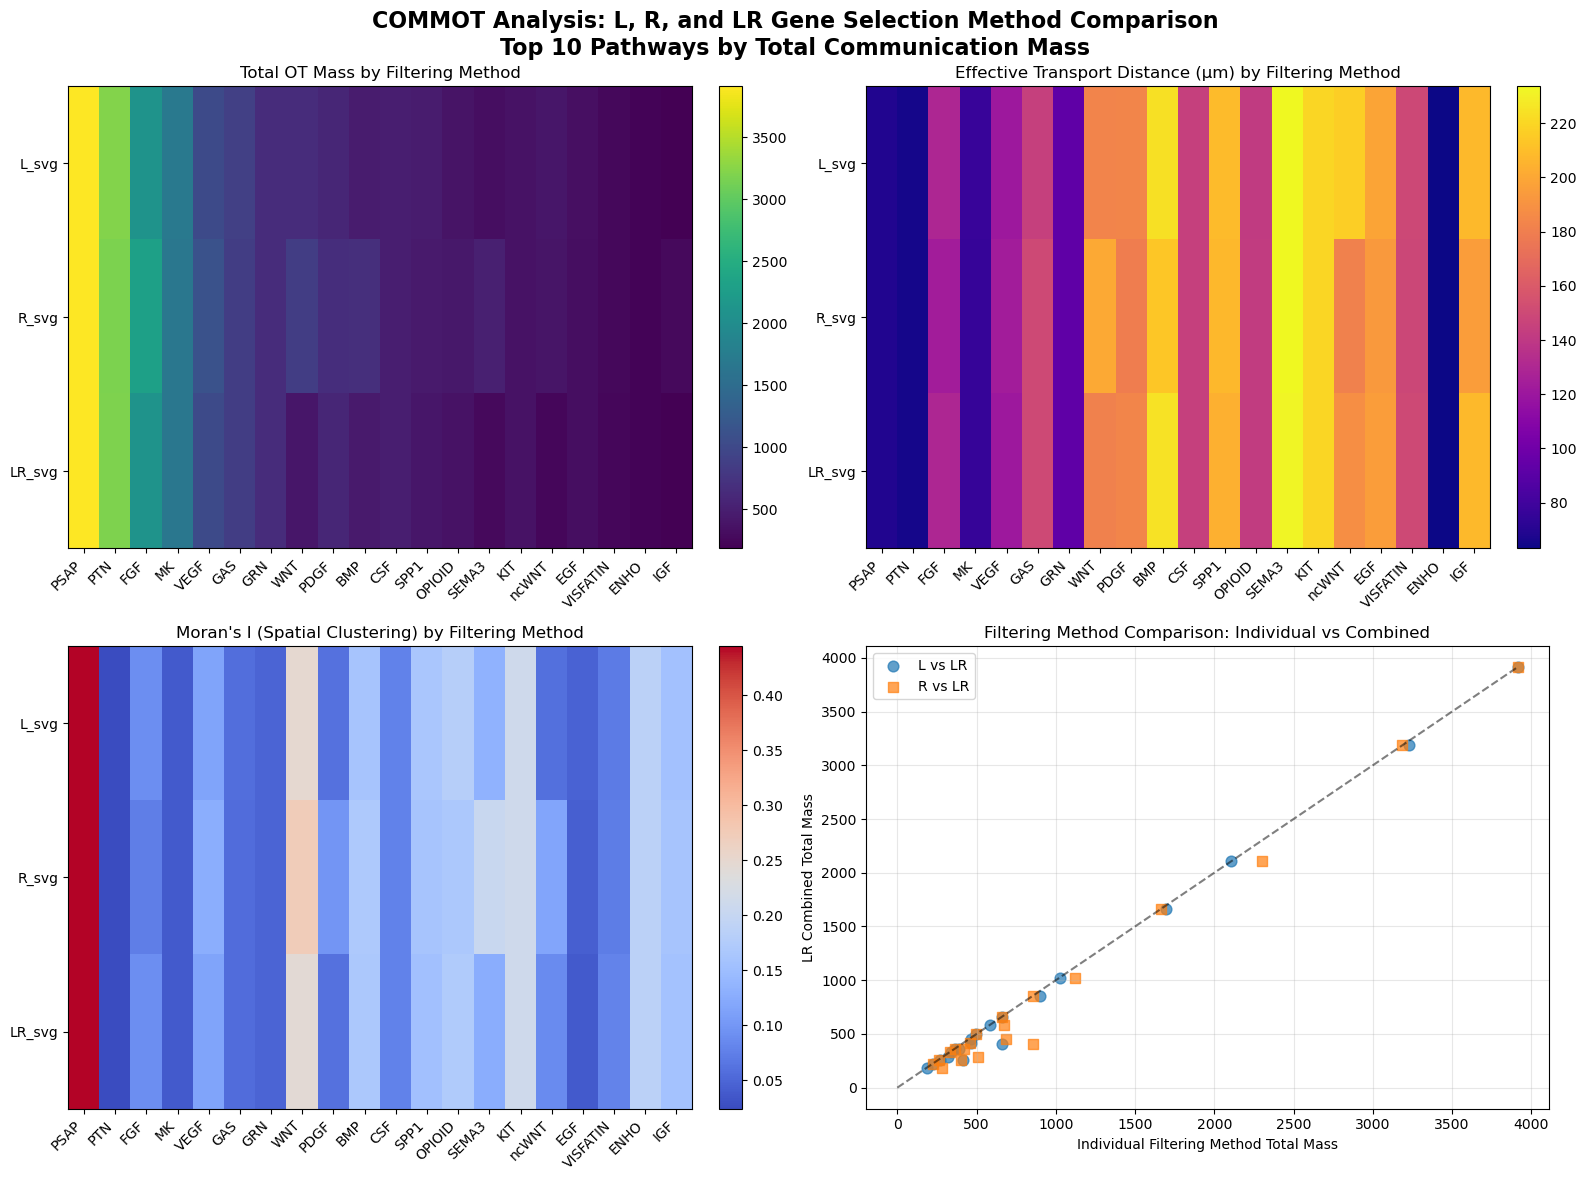


Summary Statistics:

L_svg:
  Total mass across pathways: 18703.11
  Average transport distance: 153.65
  Average Moran's I: 0.129

R_svg:
  Total mass across pathways: 19664.73
  Average transport distance: 151.24
  Average Moran's I: 0.138

LR_svg:
  Total mass across pathways: 18033.39
  Average transport distance: 152.07
  Average Moran's I: 0.129


In [16]:
# side by side comparison of L, R, LR results for selected pathways

# check available pathways in the data
print("Available pathways in L_svg:")
l_pathways = [k for k in commot_L_svg.obsp.keys() if 'commot-cellchat' in k and len(k.split('-')) == 3]
print(f"Found {len(l_pathways)} pathways:", l_pathways[:5])

print("\nAvailable pathways in R_svg:")
r_pathways = [k for k in commot_R_svg.obsp.keys() if 'commot-cellchat' in k and len(k.split('-')) == 3]
print(f"Found {len(r_pathways)} pathways:", r_pathways[:5])

print("\nAvailable pathways in LR_svg:")
lr_pathways = [k for k in commot_LR_svg.obsp.keys() if 'commot-cellchat' in k and len(k.split('-')) == 3]
print(f"Found {len(lr_pathways)} pathways:", lr_pathways[:5])

# get common pathways
common_pathways_all = sorted(set(l_pathways).intersection(r_pathways).intersection(lr_pathways))
print(f"\nCommon pathways across all three: {len(common_pathways_all)}")

# comparison plots using total pathway activity
if len(common_pathways_all) > 0:
    # get top pathways by total mass for comparison
    pathway_masses = {}
    for pathway_key in common_pathways_all:
        total_mass_l = total_mass(commot_L_svg, pathway_key)
        total_mass_r = total_mass(commot_R_svg, pathway_key)
        total_mass_lr = total_mass(commot_LR_svg, pathway_key)
        pathway_masses[pathway_key] = total_mass_l + total_mass_r + total_mass_lr
    
    # sort by total mass and select top pathways
    top_pathways = sorted(pathway_masses.items(), key=lambda x: x[1], reverse=True)[:20]
    
    print(f"\nTop 10 pathways by total mass:")
    for pathway, mass in top_pathways:
        print(f"  {pathway.split('-')[-1]}: {mass:.2f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # get data for heatmap
    pathway_names = [p[0].split('-')[-1] for p in top_pathways]
    methods = ['L_svg', 'R_svg', 'LR_svg']
    data_objects = [commot_L_svg, commot_R_svg, commot_LR_svg]
    
    # plot 1 -> total OT mass heatmap
    mass_data = np.zeros((len(methods), len(pathway_names)))
    for i, (pathway_key, _) in enumerate(top_pathways):
        for j, data_obj in enumerate(data_objects):
            mass_data[j, i] = total_mass(data_obj, pathway_key)
    
    im1 = axes[0, 0].imshow(mass_data, cmap='viridis', aspect='auto')
    axes[0, 0].set_xticks(range(len(pathway_names)))
    axes[0, 0].set_xticklabels(pathway_names, rotation=45, ha='right')
    axes[0, 0].set_yticks(range(len(methods)))
    axes[0, 0].set_yticklabels(methods)
    axes[0, 0].set_title('Total OT Mass by Filtering Method')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # plot 2 -> effective transport distance heatmap
    distance_data = np.zeros((len(methods), len(pathway_names)))
    for i, (pathway_key, _) in enumerate(top_pathways):
        for j, data_obj in enumerate(data_objects):
            distance_data[j, i] = effective_transport_distance(data_obj, pathway_key)
    
    # Mask NaN values
    distance_data_masked = np.ma.masked_invalid(distance_data)
    im2 = axes[0, 1].imshow(distance_data_masked, cmap='plasma', aspect='auto')
    axes[0, 1].set_xticks(range(len(pathway_names)))
    axes[0, 1].set_xticklabels(pathway_names, rotation=45, ha='right')
    axes[0, 1].set_yticks(range(len(methods)))
    axes[0, 1].set_yticklabels(methods)
    axes[0, 1].set_title('Effective Transport Distance (µm) by Filtering Method')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Plot 3: Moran's I heatmap
    moran_data = np.zeros((len(methods), len(pathway_names)))
    for i, (pathway_key, _) in enumerate(top_pathways):
        for j, data_obj in enumerate(data_objects):
            moran_data[j, i] = morans_I_sender(data_obj, pathway_key, k_neighbors=8)
    
    # mask NaN values
    moran_data_masked = np.ma.masked_invalid(moran_data)
    im3 = axes[1, 0].imshow(moran_data_masked, cmap='coolwarm', aspect='auto')
    axes[1, 0].set_xticks(range(len(pathway_names)))
    axes[1, 0].set_xticklabels(pathway_names, rotation=45, ha='right')
    axes[1, 0].set_yticks(range(len(methods)))
    axes[1, 0].set_yticklabels(methods)
    axes[1, 0].set_title("Moran's I (Spatial Clustering) by Filtering Method")
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # plot 4 -> filtering method comparison scatter plot
    # compare L_svg vs LR_svg for total OT mass
    l_masses = [total_mass(commot_L_svg, p[0]) for p in top_pathways]
    lr_masses = [total_mass(commot_LR_svg, p[0]) for p in top_pathways]
    r_masses = [total_mass(commot_R_svg, p[0]) for p in top_pathways]
    
    axes[1, 1].scatter(l_masses, lr_masses, alpha=0.7, s=60, label='L vs LR', marker='o')
    axes[1, 1].scatter(r_masses, lr_masses, alpha=0.7, s=60, label='R vs LR', marker='s')
    
    # add diagonal line 
    all_masses = l_masses + lr_masses + r_masses
    max_val = max(all_masses)
    axes[1, 1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    axes[1, 1].set_xlabel('Individual Filtering Method Total Mass')
    axes[1, 1].set_ylabel('LR Combined Total Mass')
    axes[1, 1].set_title('Filtering Method Comparison: Individual vs Combined')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    fig.suptitle('COMMOT Analysis: L, R, and LR Gene Selection Method Comparison\n'
                 'Top 10 Pathways by Total Communication Mass', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # summary statistics
    print("\nSummary Statistics:")
    for i, method in enumerate(methods):
        total_mass_sum = np.sum(mass_data[i, :])
        avg_distance = np.nanmean(distance_data[i, :])
        avg_moran = np.nanmean(moran_data[i, :])
        
        print(f"\n{method}:")
        print(f"  Total mass across pathways: {total_mass_sum:.2f}")
        print(f"  Average transport distance: {avg_distance:.2f}")
        print(f"  Average Moran's I: {avg_moran:.3f}")

else:
    print("No common pathways found across all three methods.")

### Top left: total OT mass by method
- Signaling strength is invariant across filtering selection methods

### Top right: effective transport distance by method
- Pathways show different ranges of transport; but these ranges are preserved across the different filtering methods

### Bottom left: moran's I 
- Strong clustering for PSAP and Wnt signaling pathways
- L and LR signaling share trends

### Bottom right: L vs LR OT total mass (each pt = one pathway)
- points are close to the diagonal -> LR combined signaling is additive with respoect to L and R contributions
    - using LR selection doesn't introduce non linear artifacts 
    - COMMOT results are similar between the signaling filtering methods

**Filtering method does not influence gene selection. Total signaling strength is stable and spatial range is pathway specific.**
**COMMOT-inferred spatial signaling programs are stable across ligand- and receptor-only and ligand-receptor gene selection methods. This shows that SVG-drien spatial organization is a true trend rather than technical arifact of COMMOT**